# Canonical Transformations

celmech provides functionality for doing canonical transformations, and convenience classes for the types of transformations that come up most often. We start by creating a REBOUND simulation of a 2 planet system near the 3:2 MMR, and create a Hamiltonian that includes various eccentricity and inclination 3:2 terms as well as secular terms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound as rb
from celmech import PoincareHamiltonian,Poincare
from celmech.canonical_transformations import CanonicalTransformation

import sympy
from sympy import init_printing
init_printing()

In [2]:
from celmech.disturbing_function import list_resonance_terms

In [3]:
def get_pham(pvars,max_order = 3 ):
    pham = PoincareHamiltonian(pvars)
    pham.add_MMR_terms(3,1,max_order=max_order,inclinations=False)
    pham.add_secular_terms(max_order=max_order,inclinations=False)
    return pham

In [4]:
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=3e-5,P=1, e=0.01, inc=0.01)
sim.add(m=3e-5,P=1.5, e=0.02, pomega=np.pi, inc=0.02, Omega=np.pi)
sim.move_to_com()

In [5]:
pvars = Poincare.from_Simulation(sim)
pham=PoincareHamiltonian(pvars)
pham = get_pham(pvars)

The Hamiltonian looks messy in part because, by default, celmech uses Cartesian elements for the eccentricities and inclinations. So one transformation that routinely comes up is to new angles that are linear combinations of the various Poincare angles. This transformation is always canonical.

## Transformation 1: To new linear combinations of the default Poincare angles

Create transfromation from poincare variables to new variables using

$$
    \begin{pmatrix}
    Q_1\\
    \vdots\\
    Q_{3N}
    \end{pmatrix}
     = 
     A
     \cdot
    \begin{pmatrix}
    \lambda_1\\
    \vdots\\
    \lambda_N\\
    \gamma_1\\
    \vdots\\
    \gamma_N\\
    q_1\\
    \vdots\\q_N\end{pmatrix} 
$$

We only have to specify the array $A$, where each row corresponds to the linear combinations for each new angle:

In [6]:
A = np.array([
    [-2,3,0,0,0,0],
    [1,-1,0,0,0,0],
    [-2,3,+1,0,0,0],
    [-2,3,0,+1,0,0],
    [-2,3,0,0,+1,0],
    [-2,3,0,0,0,+1]
])
new_angles_tr = CanonicalTransformation.from_poincare_angles_matrix(pvars,A)

We can check whether the transformation we put in matches up with what we desired by checking the rule it created for the new variables in terms of the old:

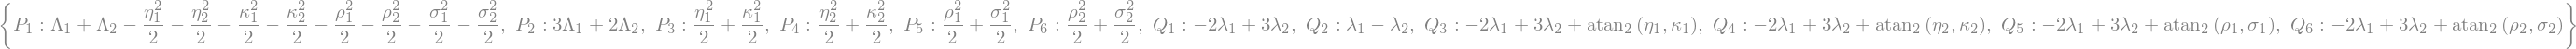

In [7]:
new_angles_tr.new_to_old_rule

We can see the that the new angles $Q_i$ follow the linear combinations specified by $A$, and the new actions $P_i$ are determined automatically from the requirement that the transformation be canonical. We can also use this transformation instance to transform our Hamiltonian to our new variables, which simplifies things considerably (most variables are constants if you check `new_ham.NH`)

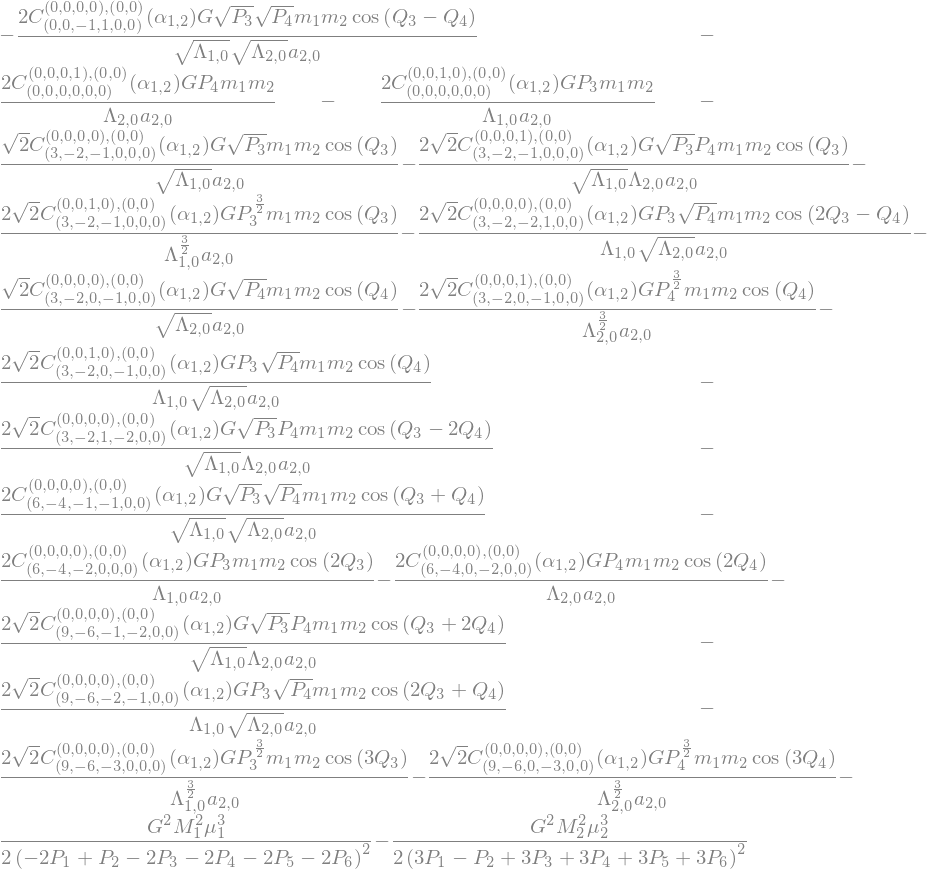

In [8]:
new_ham = new_angles_tr.old_to_new_hamiltonian(pham)
new_ham.H

## Transformation 2: polar to cartesian

Another transformation that comes up frequently is going back and forth between polar and cartesian variables. For the transformation to be canonical, this implies a relationship going from variables $(P_i,Q_i)$ to $(x_i,y_i) = \sqrt{2P_i}\times(\cos Q_i, \sin Q_i)$.

If we have a set of coordinates and momenta

In [9]:
new_ham.qp_pairs

we can choose to only transform a subset of these $(P,Q)$ pairs by passing a list of indices that should be transformed (note that these indices start at 0, so $(P_1, Q_1)$ corresponds to index 0). To only convert the last 4 $(P,Q)$ pairs we do

In [10]:
to_cart_tr = CanonicalTransformation.polar_to_cartesian(new_ham.qp_vars,indices=[2,3,4,5])

and can check the resulting transformation equations:

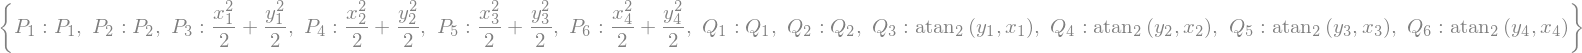

In [11]:
to_cart_tr.old_to_new_rule

The Hamiltonian in the new cartesian variables is

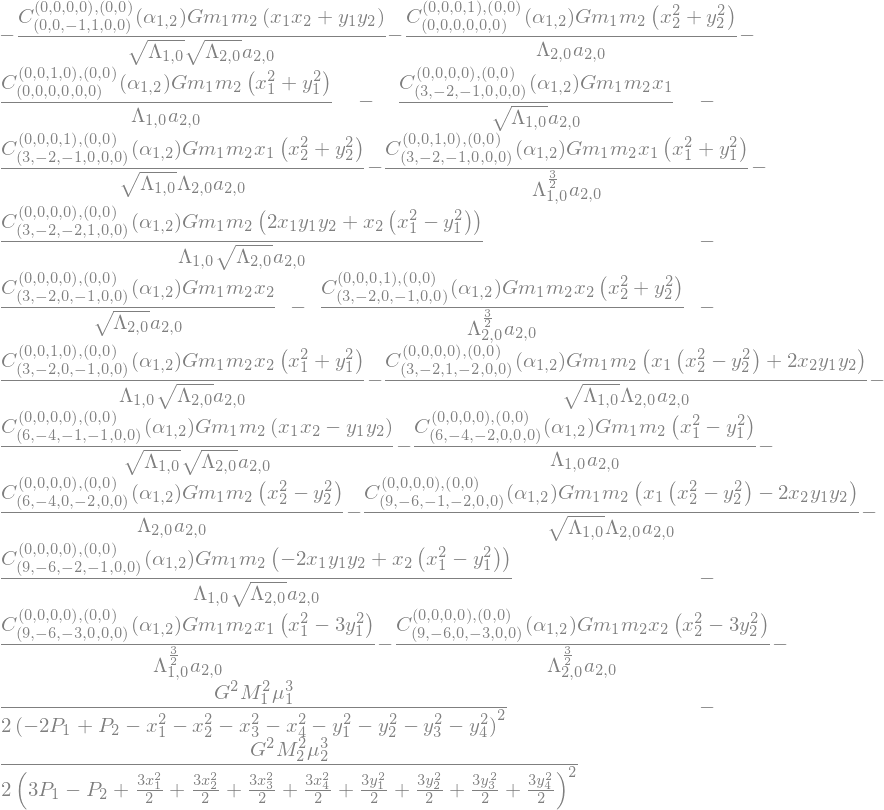

In [12]:
new_ham_cart = to_cart_tr.old_to_new_hamiltonian(new_ham)
new_ham_cart.H

## Composite Transformations

We often want to chain sequences of transformations. For example, to concatenate the above two transformations (note order matters, we want to do the angle transformation first):

In [13]:
trans = CanonicalTransformation.composite([new_angles_tr, to_cart_tr])

We are also often interested in expressing our final variables all the way back in terms of the original ones, which we can do with

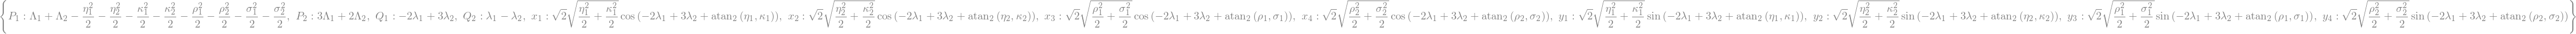

In [14]:
trans.new_to_old_rule

Unfortunately, if we use this new transformation to go from our original Hamiltonian instance `pham` to one in the new variables (in a single step) we get a mess. 

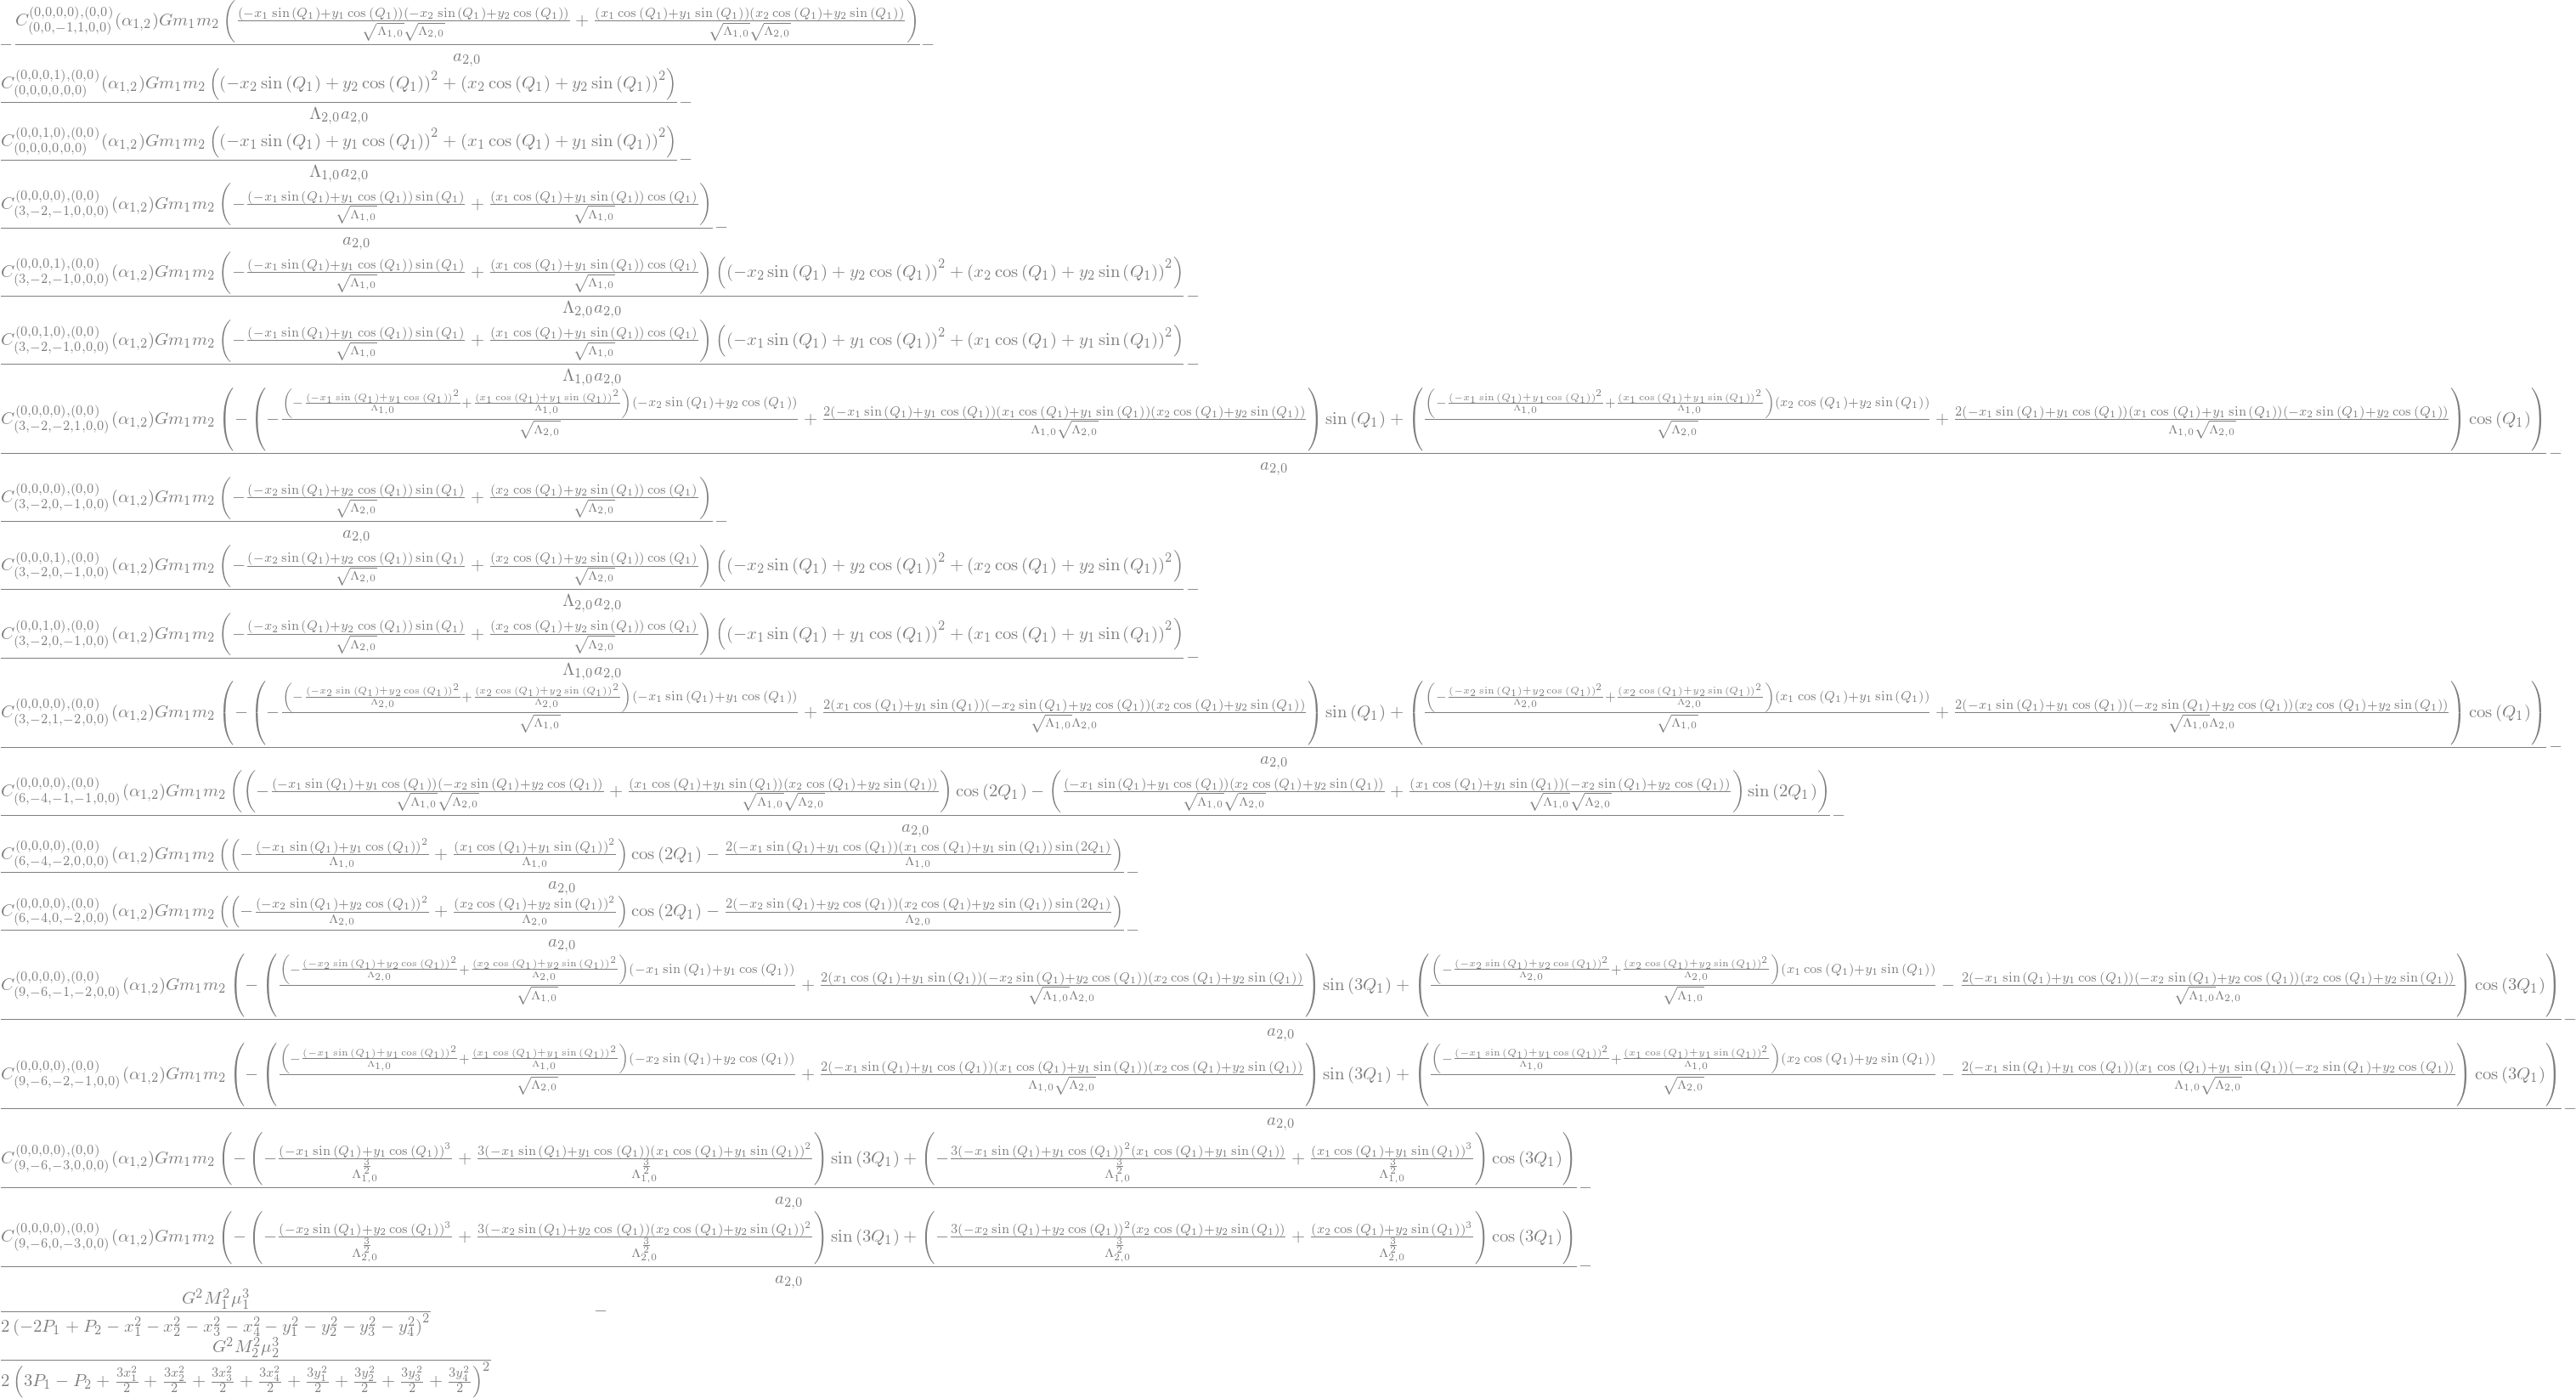

In [15]:
transham = trans.old_to_new_hamiltonian(pham)
transham.H

`sympy` will not always find all the appropriate simplifications, and while `celmech` can provide it with the appropriate hints behind the scenes for simple cases like the `polar_to_cartesian` transformation above, it can't handle all general composite transfomrations. This is a place where you have to experiment manually. All `CanonicalTransformation` classes allow you to manually pass a function that takes a `sympy` expression and returns a simplified one. It can sometimes help `sympy` to simplify expressions term by term. You could do that with

`simpfunction = lambda x: x.func(*[do_what_you_want(term) for term in x.args])`

In our case we we can get `sympy` to simplify things by first applying a trigonometric simplification to each term: 

In [16]:
from sympy import simplify, trigsimp
o2n_simplify = lambda x: x.func(*[simplify(trigsimp(term)) for term in x.args])

Now if we create our transformation with this simplification function to be applied when transforming from old to new variables, if we transform our original Hamiltonian `pham`, we get back the simpler expression we obtained above:

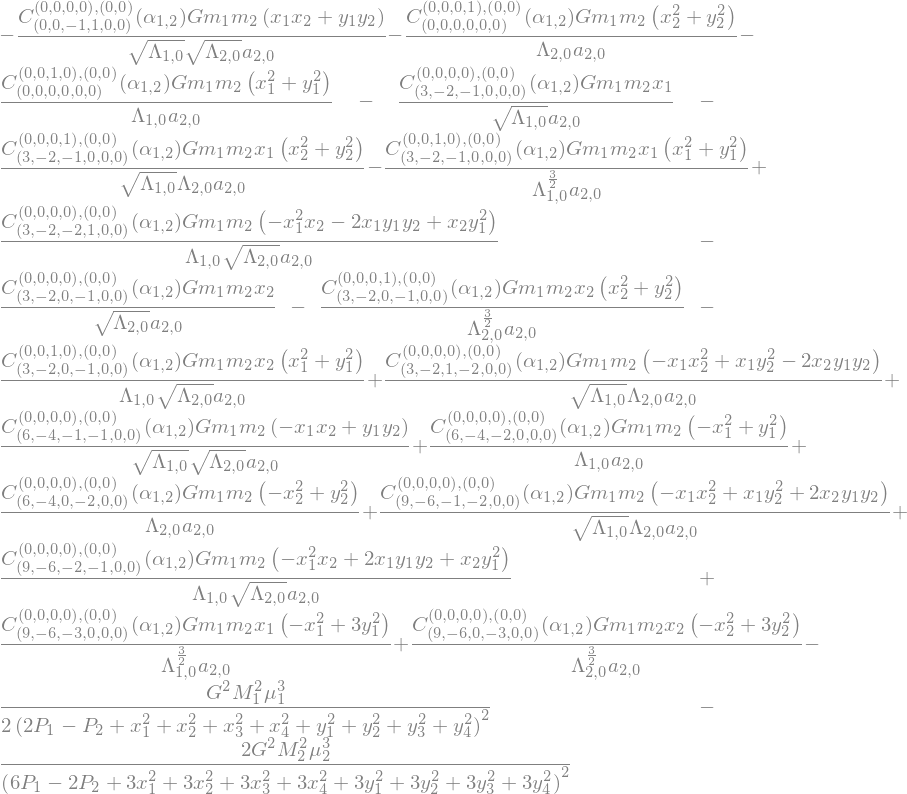

In [17]:
trans = CanonicalTransformation.composite([new_angles_tr, to_cart_tr], old_to_new_simplify=o2n_simplify)
transham = trans.old_to_new_hamiltonian(pham)
transham.H

## Conserved Quantities and Extracting Variables

Through the clever choices of canonical transformations above, two of our new angles, $Q_1$ and $Q_2$, do not show up in our Hamiltonian above, implying that their conjugate momenta $P_1$ and $P_2$ are conserved. $Q_1$ and $Q_2$ might still evolve in complicated ways since the Hamiltonian still depends on $P_1$ and $P_2$, but they do not feed back on the remaining degrees of freedom $x_i$ and $y_i$.

To avoid indexing errors extracting variables, it can be useful to use the $qp$ dictionary using the variable's `sympy` symbol as the key. You can check what it should be like this

In [18]:
transham.qp_vars[6]

In [19]:
transham.qp_vars[6].name

'P1'

we can then access it by turning that string into a `sympy` symbol (note the `real=True` kwarg is neccessary to ensure the symbol returned by `symbols` matches the variables stored as `transham.qp` keys):

In [20]:
from sympy import symbols
from sympy.core import assumptions
transham.qp[symbols('P1',real=True)]

For example we can pull out the evolution of $P_1$ and $Q_1$ in this way and see that $P_1$ is conserved, while $Q_1$ is not by plotting their fractional change:

In [21]:
Nout = 1000
times = np.linspace(0, 1000, Nout)
P1, Q1 = np.zeros(Nout), np.zeros(Nout)
for i, t in enumerate(times):
    transham.integrate(t)
    P1[i] = transham.qp[symbols('P1',real=True)]
    Q1[i] = transham.qp[symbols('Q1',real=True)]

Text(0, 0.5, 'Fractional Change')

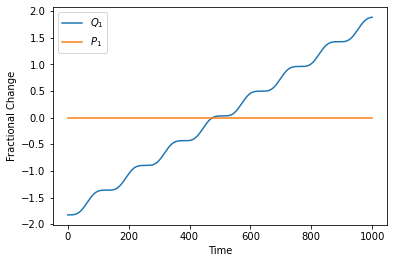

In [22]:
fig, ax = plt.subplots()
ax.plot(times, (Q1-Q1.mean())/Q1.mean(), label=r'$Q_1$')
ax.plot(times, (P1-P1.mean())/P1.mean(), label=r'$P_1$')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Fractional Change')

## Reducing the number of degrees of freedom

In many cases, we therefore don't care about tracking/integrating the $(Q_1, P_1)$ and $(Q_2, P_2)$ degrees of freedom, but we run into a problem if we ever want to go from our new variables back to our original variables, since we then have fewer variables than we started with. We have two options:

* A) Integrate all the degrees of freedom to also solve for the evolution of $Q_1$ and $Q_2$. This will always allow us to go back to the original variables
* B) Ignore the $(Q_1, P_1)$ and $(Q_2, P_2)$ degrees of freedom, and assume when going back to the original variables that everything remains at their initial values. This will be correct for the conserved momenta, but not for the angles. It implies that the time evolution of the original angles will be incorrect, though in many applications that won't matter

## Approach A)

We evolve both the original and transformed Hamiltonians, and store all twelve values:

In [23]:
pvars = Poincare.from_Simulation(sim)
pham = get_pham(pvars)
transham = trans.old_to_new_hamiltonian(pham)

In [24]:
Nout = 1000
times = np.linspace(0, 1000, Nout)
res = np.zeros((transham.N_dim, Nout))
res_orig = np.zeros((pham.N_dim, Nout))
for i, t in enumerate(times):
    transham.integrate(t)
    pham.integrate(t)
    res[:,i] = transham.values
    res_orig[:,i] = pham.values

Now if we transform the results with our transformed Hamiltonian back to the original variables (orange), we see that they overlap with the integration done in the original variables (blue):

Text(0, 0.5, '$\\Lambda_1$')

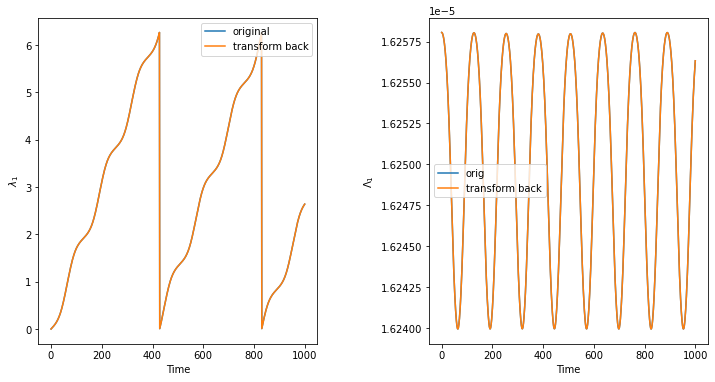

In [25]:
transform_back = trans.new_to_old_array(res)

fig, axarr = plt.subplots(ncols=2, figsize=(12,6))
fig.subplots_adjust(wspace=0.4)
axarr[0].plot(times, np.mod(res_orig[0], 2*np.pi), label='original')
axarr[0].plot(times, np.mod(transform_back[0], 2*np.pi), label='transform back')
axarr[0].legend()
axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('$\lambda_1$')
axarr[1].plot(times, res_orig[6], label='orig')
axarr[1].plot(times, transform_back[6], label='transform back')
axarr[1].legend()
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel('$\Lambda_1$')

## Approach B)

Here we reduce the phase space, by not tracking the degrees of freedom with conserved momenta $(Q_1, P_1)$ and $(Q_2, P_2)$.

In [26]:
new_ham_cart = to_cart_tr.old_to_new_hamiltonian(new_ham,do_reduction=True)

Because we've reduced the phase space, `values` now has 8 elements, but we can get all 12 with `full_values`:

In [27]:
print(len(new_ham_cart.values))

8


In [28]:
print(len(new_ham_cart.full_values))

12


If we plan to transform back to the original variables, we need all 12 variables to pass to our transformation object, so we need to store `full_values` at each timestep

In [29]:
res_reduced = np.zeros((transham.N_dim, Nout))
for i, t in enumerate(times):
    new_ham_cart.integrate(t)
    res_reduced[:,i] = new_ham_cart.full_values

Now we can again compare the results from the integration with the original Hamiltonian to the one using the transformed Hamiltonian, after transforming back to the original variables (orange).

We see that because the reduced Hamiltonian `new_ham_cart` is not integrating the angles $Q_1$ and $Q_2$ (they just remain at their initial value), we don't get the correct original angles when we transform back.
However, our original variables $\Lambda_1$ that only depend on the new actions are fine, because the new Hamiltonian correctly treats the conserved $P_1$ and $P_2$ as constant.
For many applications we are not specifically interested in the angles, so this is fine

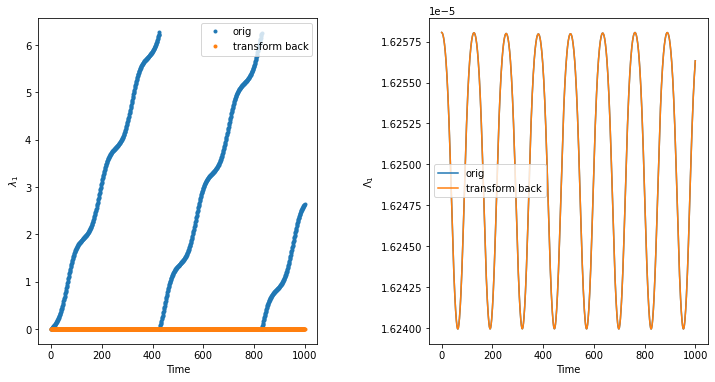

In [30]:
transform_back_reduced = trans.new_to_old_array(res_reduced)

fig, axarr = plt.subplots(ncols=2, figsize=(12,6))
fig.subplots_adjust(wspace=0.4)
axarr[0].plot(times, np.mod(res_orig[0], 2*np.pi), '.', label='orig')
axarr[0].plot(times, np.mod(transform_back_reduced[0], 2*np.pi), '.', label='transform back')
axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('$\lambda_1$')
axarr[0].legend()
axarr[1].plot(times, res_orig[6], label='orig')
axarr[1].plot(times, transform_back_reduced[6], label='transform back')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel('$\Lambda_1$')
axarr[1].legend()

# Let's use our new, transformed Hamiltonian to solve for equilibrium solutions.


In [31]:
# Get symbols
P1,P2 = sympy.symbols("P(1:3)",real=True)
Q1,Q2 = sympy.symbols("Q(1:3)",real=True)
xvec=sympy.symbols("x(1:5)",real=True)
yvec=sympy.symbols("y(1:5)",real=True)

We know that the equilibrium solutions should have zero inclination and zero $y$ components

In [32]:
# Set up rule
eqrule = dict(zip(yvec,np.zeros(4)))
eqrule.update(dict(zip(xvec[2:],np.zeros(2))))

# Below, we'll vary P1 and solve for different equilibria
pars = new_ham_cart.H_params.copy()
P10 = pars.pop(P1)

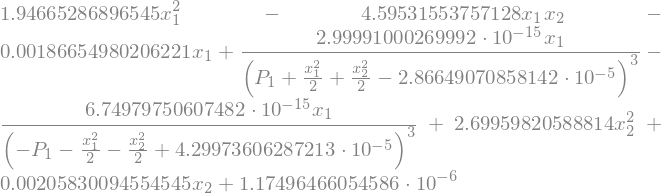

In [33]:
# set up functions for root-finding
fn = new_ham_cart.flow.subs(eqrule).subs(pars)[:2]
Dfn = sympy.Matrix(2,2,lambda i,j: sympy.diff(fn[i],xvec[j]))

# Show expression for fn[0]
fn[0]

In [34]:
# Lambdify functions for root-finding
from scipy.optimize import root
fnN=sympy.lambdify([xvec[0],xvec[1],P1],fn)
DfnN=sympy.lambdify([xvec[0],xvec[1],P1],Dfn)

In [35]:
cart_state = new_ham_cart.state

# Array to store equilibria
Nout = 30
eq_dyvars_cart = np.zeros((Nout,len(to_cart_tr.new_qp_vars)))
eq_dyvars_poincare = np.zeros((Nout,pvars.N_dim))

iQ1 = to_cart_tr.new_qp_vars.index(Q1)
iQ2 = to_cart_tr.new_qp_vars.index(Q2)

iP1 = to_cart_tr.new_qp_vars.index(P1)
iP2 = to_cart_tr.new_qp_vars.index(P2)

ix1 = to_cart_tr.new_qp_vars.index(xvec[0])
ix2 = to_cart_tr.new_qp_vars.index(xvec[1])



eq_dyvars_cart[:,iQ1] = float(Q1.subs(new_ham.state.qp))
eq_dyvars_cart[:,iQ2] = float(Q2.subs(new_ham.state.qp))
eq_dyvars_cart[:,iP2] = new_ham_cart.H_params[P2]


# Note--
# P1 ~ (L10 + L20) - (L10*e1^2/2 + L20*e2^2/2)
########################################################
emax = 0.05

from celmech.poincare import _get_Lambda0_symbol
L10_val,L20_val = [pham.H_params[_get_Lambda0_symbol(i)] for i in range(1,3)]
###################################

P1vals = P10 + np.linspace(1,-2,Nout) * (L10_val + L20_val) * emax**2
eq_dyvars_cart[:,iP1] = P1vals

guess = np.zeros(2)
for i,P1val in enumerate(P1vals):
    # Solve for equilibrium
    soln = root(lambda x: fnN(*x,P1val),guess,jac = lambda x: DfnN(*x,P1val))
    guess = soln.x
    x1eq,x2eq = guess
    eq_dyvars_cart[i,ix1] = x1eq
    eq_dyvars_cart[i,ix2] = x2eq 
    
    # Invert transformationf
    polar_eq = to_cart_tr.new_to_old_array(eq_dyvars_cart[i])
    
    poincare_eq = new_angles_tr.new_to_old_array(polar_eq)
    
    eq_dyvars_poincare[i] = poincare_eq

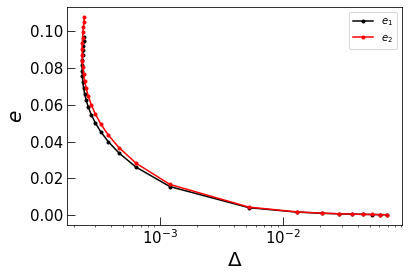

In [36]:
e1,e2,Delta = np.zeros((3,Nout))
for i,eq in enumerate(eq_dyvars_poincare):
    pvars.values = eq
    e1[i] = pvars.particles[1].e
    e2[i] = pvars.particles[2].e
    
    per1 = pvars.particles[1].P
    per2 = pvars.particles[2].P
    
    Delta[i] = 2 * per2 / per1 / 3 - 1

plt.plot(Delta,e1,'k.-', label=r'$e_1$')
plt.plot(Delta,e2,'r.-', label=r'$e_2$')
plt.xlabel("$\Delta$",fontsize=20)
plt.ylabel("$e$",fontsize=20)
plt.xscale('log')
plt.tick_params(labelsize=15,direction='in',size=8)
plt.legend()

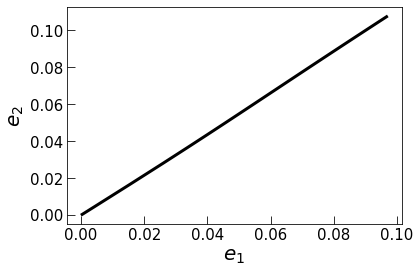

In [37]:
plt.plot(e1,e2,'k-',lw=3)
plt.xlabel("$e_1$",fontsize=20)
plt.ylabel("$e_2$",fontsize=20)
plt.tick_params(labelsize=15,direction='in',size=8)